# Import Packages, Functions, and Data


## Install packages

In [ ]:
# Install packages
!pip install atomai --upgrade
!pip install gpim
!wget -qq https://bitbucket.org/piraynal/pydm3reader/get/d06ab6b3aa0f.zip
!pip install pysptools
!git clone https://github.com/pycroscopy/AICrystallographer.git
!cp -r AICrystallographer/AtomNet/* .
!gdown https://drive.google.com/uc?id=1K46kbZoqFV2ao-xPDNN1oDrDSCogqBSp

# Import data files
!git clone https://github.com/nccreang/AE_Workflows.git
!cp -r AE_Workflows/Data/* .
!rm -r AE_Workflows

     |████████████████████████████████| 153kB 8.3MB/s 
     |████████████████████████████████| 194kB 12.6MB/s 
     |████████████████████████████████| 501kB 14.8MB/s 
     |████████████████████████████████| 870kB 15.0MB/s 
  Created wheel for mendeleev: filename=mendeleev-0.6.1-py2.py3-none-any.whl size=174981 sha256=f87962c7adf17dcff6640a9f10226893b68b6b9caf8e7a3f616ea5a38449857a
  Stored in directory: /root/.cache/pip/wheels/fb/28/5d/95e69a718b35dd00169889b0139a692f6c265d399cab3aa097
Successfully built mendeleev
     |████████████████████████████████| 686kB 9.7MB/s 
     |████████████████████████████████| 8.1MB 9.5MB/s 
  Created wheel for pysptools: filename=pysptools-0.15.0-cp37-none-any.whl size=8133752 sha256=3da9d90dfed4edb0d9cfd78325c3c6e236e76f32240a250847d99118470f8d3b
  Stored in directory: /root/.cache/pip/wheels/bf/60/be/a6719d91bfa59135201feb034c7069e4146aa576fc0dc9e624
Successfully built pysptools
Cloning into 'AICrystallographer'...
remote: Enumerating objects: 1704, do

##Load packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from copy import deepcopy

import glob
import os
from scipy import fftpack
from scipy import ndimage
import pysptools.abundance_maps as amp
from mpl_toolkits.axes_grid1 import make_axes_locatable
import gpim
import h5py

import atomai as aoi
from atomai import utils
import torch
import dcnn

##Define functions

In [ ]:
def ApplyHamming(imgsrc):
    #Applies a Hamming window to the input imgsec, returns the window after filter applied.
    bw2d = np.outer(np.hamming(window_size), np.ones(window_size))
    bw2d = np.sqrt(bw2d * bw2d.T) 
    imgsrc *= bw2d
    return imgsrc
    
def MakeWindow(imgsrc, xpos, ypos):
    #Returns the portion of the image within the window given the
    #image (imgsrc), the xposition and the yposition
    imgsrc = imgsrc[xpos:xpos+window_size, ypos:ypos+window_size]
    return imgsrc

def GenerateXYPos(window_size, window_step, image_width):   
    #Generates the (x,y) pairs given the window size, window step and image width (=height)
    xpos_vec = np.arange(0,image_width-window_size,window_step)
    ypos_vec = np.arange(0,image_width-window_size,window_step)
    num_steps = len(xpos_vec)       
    xpos_mat = np.tile(xpos_vec, num_steps)
    ypos_mat = np.repeat(ypos_vec, num_steps)
    pos_mat = np.column_stack((xpos_mat, ypos_mat))
              
    return pos_mat

def zoom_interpol(FFT_image):   
    #Accepts an image, returns zoomed image
    zoom_size = (FFT_image.shape[0]/FFT_zoom_factor)/2
    if np.mod(FFT_image.shape[0]/FFT_zoom_factor,2)==0:
        F2_zoomed= FFT_image[int(window_size/2 - zoom_size):int(window_size/2 + zoom_size), 
                             int(window_size/2 - zoom_size):int(window_size/2 +zoom_size)]
    else:                    
        F2_zoomed= FFT_image[int(window_size/2 - zoom_size):int(window_size/2+1 + zoom_size), 
                             int(window_size/2 - zoom_size):int(window_size/2 + 1+zoom_size)]
    
    return ndimage.zoom(F2_zoomed,interpol_factor)
    
def plot_FFT_window(FFT_final, option):   #1 for normal, option is str defining plot type
    plt.figure()
    plt.cla()

    if option =='log':
        plt.imshow(np.log(abs(FFT_final)), interpolation = 'none',cmap='plasma')    
        
    elif option =='sqrt':
        plt.imshow(np.sqrt(abs(FFT_final)), interpolation = 'none',cmap='plasma')    

    else:
        plt.imshow(abs(FFT_final), interpolation = 'none',cmap='plasma')    
        
def Do_Sliding_FFT():
    #Carries out the FFT
    FFT_mat4 = np.zeros(shape = (len(pos_mat), 
                                 int(window_size*interpol_factor/FFT_zoom_factor), 
                                 int(window_size*interpol_factor/FFT_zoom_factor)))

    for i in np.arange(0,len(pos_mat)):
        
        img_window = MakeWindow(raw_image, pos_mat[i,0], pos_mat[i,1]) #Generate the window on which FFT is performed
                               
        #Pass the x and y positions of the top-left corner of the FFT window
        #These positions are located in pos_mat
        
        if hamming_filter ==1: #Apply filter if requested
            img_window_filtered = ApplyHamming(np.copy(img_window))
        else:
            img_window_filtered = (np.copy(img_window))
        
        # Take the fourier transform of the image.
        F1 = fftpack.fft2((img_window_filtered)) 
        
        # Now shift so that low spatial frequencies are in the center.
        F2 = (fftpack.fftshift((F1)))
       
        final_FFT = zoom_interpol(np.abs(F2))
        
        FFT_mat4[i,:,:,] = final_FFT

    return FFT_mat4


def Do_Sliding():
    #Carries out the sliding window
    mat4 = np.zeros(shape = (len(pos_mat), 
                                 int(window_size*interpol_factor/FFT_zoom_factor), 
                                 int(window_size*interpol_factor/FFT_zoom_factor)))

    for i in np.arange(0,len(pos_mat)):
        
        img_window = MakeWindow(raw_image, pos_mat[i,0], pos_mat[i,1]) #Generate the window on which FFT is performed
        
        mat4[i,:,:,] = img_window

    return mat4

    





In [ ]:
def acq(gpmodel, X_full, X_sparse): # leave it as is
  mean, sd = gpmodel.predict(X_full, verbose=0) # leave it as is
  acq = 1 * mean + 4 * sd
  return acq, (mean, sd) # leave it as is


def trial_func(idx):
    """Takes a list of indices as input and returns function value at these indices"""
    return aimg[idx[0], idx[1]]

def get_mask(aimg, points_measured, border_px = 3):
    
    #Get row, col size
    pos_dim_sizes = (aimg.shape[0], aimg.shape[1])
    
    #create mask
    mask = np.full(shape=pos_dim_sizes, fill_value = np.nan)

    #create border
    mask[border_px:-border_px, border_px:-border_px] = 1.0
    
    #Get measured points as (x,y) list
    points_measured_xy = []
    for point in points_measured: 
        points_measured_xy.append(pix_to_xy(point, pos_dim_sizes[-1]))
    
    for (x,y) in points_measured_xy:
        mask[x,y] = np.nan
    
    return mask

def pix_to_xy(pixind, num_cols):
  col = int(pixind % (num_cols))
  row =int(np.floor(pixind/ num_cols))
  return row, col

def xy_to_pixind(row,col,num_cols):
  return row*num_cols + col

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class conv2dblock(nn.Module):
    '''
    Creates a block consisting of convolutional
    layer, leaky relu and (optionally) dropout and
    batch normalization
    '''
    def __init__(self, input_channels, output_channels,
                 kernel_size=3, stride=1, padding=1,
                 use_batchnorm=False, lrelu_a=0.01,
                 dropout_=0):
        '''
        Args:
            input_channels: number of channels in the previous/input layer
            output_channels: number of the output channels for the present layer
            kernel_size: size (in pixels) of convolutional filter
            stride: value of convolutional filter stride
            padding: value of padding at the edges
            use_batchnorm (boolean): usage of batch normalization
            lrelu_a: value of alpha parameter in leaky/paramteric ReLU activation
            dropout_: value of dropout
        '''
        super(conv2dblock, self).__init__()
        block = []
        block.append(nn.Conv2d(input_channels,
                               output_channels,
                               kernel_size=kernel_size,
                               stride=stride,
                               padding=padding))
        if dropout_ > 0:
            block.append(nn.Dropout(dropout_))
        block.append(nn.LeakyReLU(negative_slope=lrelu_a))
        if use_batchnorm:
            block.append(nn.BatchNorm2d(output_channels))
        self.block = nn.Sequential(*block)

    def forward(self, x):
        '''Forward path'''
        output = self.block(x)
        return output


class upsample_block(nn.Module):
    '''
    Defines upsampling block performed either with
    bilinear interpolation followed by 1-by-1
    convolution or with a transposed convolution
    '''
    def __init__(self, input_channels, output_channels,
                 mode='interpolate', kernel_size=1,
                 stride=1, padding=0):
        '''
        Args:
            input_channels: number of channels in the previous/input layer
            output_channels: number of the output channels for the present layer
            mode: upsampling mode (default: 'interpolate')
            kernel_size: size (in pixels) of convolutional filter
            stride: value of convolutional filter stride
            padding: value of padding at the edges
            '''
        super(upsample_block, self).__init__()
        self.mode = mode
        self.conv = nn.Conv2d(
            input_channels, output_channels,
            kernel_size = kernel_size,
            stride = stride, padding = padding)
        self.conv_t = nn.ConvTranspose2d(
            input_channels, output_channels,
            kernel_size=2, stride=2, padding = 0)

    def forward(self, x):
        '''Defines a forward path'''
        if self.mode == 'interpolate':
            x = F.interpolate(
                x, scale_factor=2,
                mode='bilinear', align_corners=False)
            return self.conv(x)
        return self.conv_t(x)

class ResBlock(nn.Module):
    """
    Builds a residual block
    """
    def __init__(self, nb_filters_in=20, nb_filters_out=40, lrelu_a=0,
                use_batchnorm=False):
        """
        Args:
            nb_filters_in (int): number of channels in the block input
            nb_filters_out (int): number of channels in the block output
            lrelu_a=0 (float): negative slope value for leaky ReLU
        """
        super(ResBlock, self).__init__()
        self.lrelu_a = lrelu_a
        self.use_batchnorm = use_batchnorm
        self.c0 = nn.Conv2d(nb_filters_in,
                            nb_filters_out,
                            kernel_size=1,
                            stride=1,
                            padding=0)
        self.c1 = nn.Conv2d(nb_filters_out,
                           nb_filters_out,
                           kernel_size=3,
                           stride=1,
                           padding=1)
        self.c2 = nn.Conv2d(nb_filters_out,
                           nb_filters_out,
                           kernel_size=3,
                           stride=1,
                           padding=1)
        self.bn1 = nn.BatchNorm2d(nb_filters_out)
        self.bn2 = nn.BatchNorm2d(nb_filters_out)

    def forward(self, x):
        """Defines forward path"""
        x = self.c0(x)
        residual = x
        out = self.c1(x)
        if self.use_batchnorm:
            out = self.bn1(out)
        out = F.leaky_relu(out, negative_slope=self.lrelu_a)
        out = self.c2(out)
        if self.use_batchnorm:
            out = self.bn2(out)
        out += residual
        out = F.leaky_relu(out, negative_slope=self.lrelu_a)
        return out

class ResModule(nn.Module):
    """
    Stitches multiple convolutional blocks together
    """
    def __init__(self, input_channels, output_channels, res_depth, lrelu_a=0.01, use_batchnorm=False):
        """
        Args:
            input_channels (int): number of filters in the input layer
            output_channels (int): number of channels in the output layer
            res_depth (int): number of residual blocks in a residual module
        """
        super(ResModule, self).__init__()
        res_module = []
        for i in range(res_depth):
            input_channels = output_channels if i > 0 else input_channels
            res_module.append(
                ResBlock(input_channels, output_channels, lrelu_a=lrelu_a, use_batchnorm=use_batchnorm))
        self.res_module = nn.Sequential(*res_module)

    def forward(self, x):
        """Defines a forward path"""
        x = self.res_module(x)
        return x


class resatomsegnet_s2(nn.Module):
    '''Builds  a fully convolutional neural network model'''
    def __init__(self, nb_classes=1, nb_filters=32):
        '''
        Args:
            nb_classes (int): number of classes to be predicted
            nb_filters (int): number of filters in the first convolutional layer
        '''
        super(resatomsegnet_s2, self).__init__()
        self.pxac = 'softmax' if nb_classes > 1 else 'sigmoid'
        self.c1 = conv2dblock(1, nb_filters)
        self.c2 = ResModule(nb_filters, nb_filters*2, res_depth=2)
        self.bn = ResModule(nb_filters*2, nb_filters*4, res_depth=2)
        self.upsample_block1 = upsample_block(nb_filters*4, nb_filters*2)
        self.c3 = ResModule(nb_filters*4, nb_filters*2, res_depth=2) 
        self.upsample_block2 = upsample_block(nb_filters*2, nb_filters)
        self.c4 = conv2dblock(nb_filters*2, nb_filters)
        self.px = nn.Conv2d(nb_filters, nb_classes, kernel_size = 1, stride = 1, padding = 0)
    
    def forward(self, x):
        '''Defines a forward path'''
        # Contracting path
        c1 = self.c1(x)
        d1 = F.max_pool2d(c1, kernel_size=2, stride=2)      
        c2 = self.c2(d1)
        d2 = F.max_pool2d(c2, kernel_size=2, stride=2)      
        # Bottleneck 
        bn = self.bn(d2)
        # Expanding path
        u2 = self.upsample_block1(bn)
        u2 = torch.cat([c2, u2], dim = 1)
        u2 = self.c3(u2)
        u1 = self.upsample_block2(u2)
        u1 = torch.cat([c1, u1], dim = 1)
        u1 = self.c4(u1)
        # pixel-wise classification
        px = self.px(u1)
        if self.pxac == 'sigmoid':
            output = torch.sigmoid(px)
        elif self.pxac == 'softmax':
            output = F.log_softmax(px, dim=1)
        return output


##Load Data

**Load NiO-LSMO Data**

[1] Zhang, W. *et al.* *Materials Horizons* **7**, 3217, doi: 10.1039/d0nm01324b (2020)

[2] Kalinin, S.V. *et al.* *arXiv*, arXiv:2012.07134v07131 (2020)

[3] Gosh, A. *et al.* *npj Computational Materials*, **7**, 100, doi: 10.0138/s41524-021-00569-7 (2021)

(-0.5, 1023.5, 1023.5, -0.5)

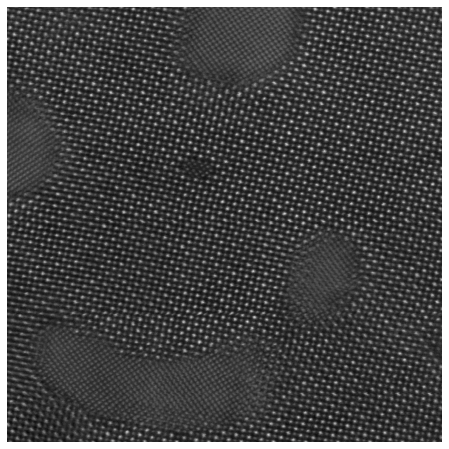

In [ ]:
imagedata = np.load('NiO_LSMO.npy')
plt.figure(figsize=(8,8))
plt.imshow(imagedata,cmap='gray')
plt.axis('off')

**Load BiFeO$_3$ Data**

[1] Ziatdinov, M. *et al.*, *Applied Physics Reviews* **8**, 011403, doi: 10.1063/5.0016792 (2021)

[2] Nelson, C.T. *et al.*, *Nat. Commun*, **11**, 6361, doi: 10.1038/s41467-020-19907-2 (2020)

[3] Nelson, C.T. *et al.*, (Zenodo, Nature Communications, 2020)

(-0.5, 2047.5, 2047.5, -0.5)

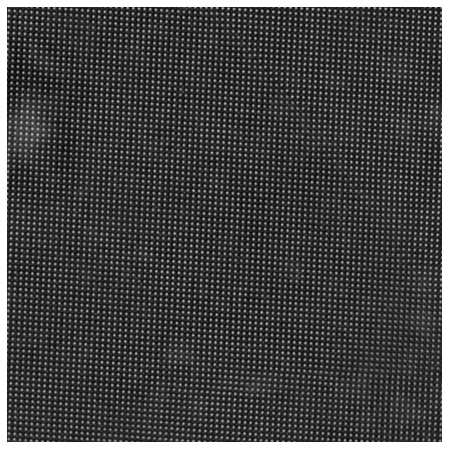

In [ ]:
imagedata = np.load('BFO.npy')
plt.figure(figsize=(8,8))
plt.imshow(imagedata,cmap='gray')
plt.axis('off')

**Load Graphene Data**

[1] Ghosh, A. *et al.*, *arXiv*, arXiv:2101.08449v08442 (2021)

[2] Kalinin, S.V. *et al.*, *arXiv*, arXiv:2010.09196v09192 (2021)

(-0.5, 1023.5, 1023.5, -0.5)

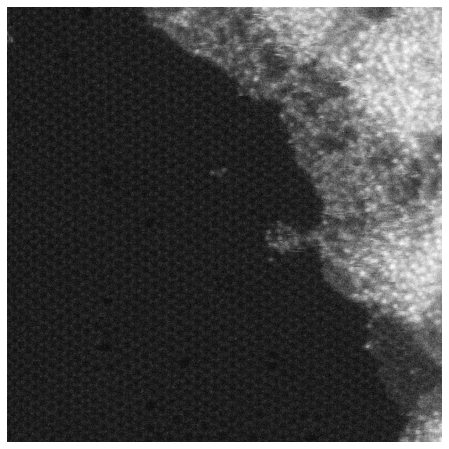

In [ ]:
imagedata = np.load('Si-Graphene.npy')
plt.figure(figsize=(8,8))
plt.imshow(imagedata,cmap='gray')
plt.axis('off')

# Image Segmentation

Perform image segmantation via sliding window FFT.  First let's set the window parameters.

In [ ]:
window_size = 64 # #x=y sizes for sliding window
window_step = 16 # #x=y sizes of each step
hamming_filter = 1 #1 for use of hamming window
FFT_zoom_factor = 2 #Zoom factor for FFT
interpol_factor = 2 #Factor for interpolation

Next, do the sliding window FFT.

In [ ]:
from matplotlib.pyplot import imread
raw_image = imagedata.astype(np.float32)
num_of_comp = 6

pos_mat = GenerateXYPos(window_size, window_step, raw_image.shape[0]) #Generate matrix with (x,y) locations of window position
stack = Do_Sliding_FFT() #Do the Sliding FFT  

# Dimensionality Reduction

Next, perform dimensionality reduction and find latent variables using a rotationaly invariant autoencoder (rVAE).

[1] Kalinin, S.V. *et al.*, *Science Advances*, eabd5084 (2021). doi:10.1126/sciadv.abd5084



In [ ]:
input_dim = (64, 64) # This is the window size, make sure batch_size matches these values
rvae = aoi.models.rVAE(input_dim, skip=True)
# rvae = rVAE2(input_dim)
rvae.fit(stack,training_cycles=200,batch_size=64,translation=True,translation_prior=0.3)

Epoch: 1/200, Training loss: 368191.1066
Epoch: 2/200, Training loss: 365939.9721
Epoch: 3/200, Training loss: 364930.6741
Epoch: 4/200, Training loss: 362777.5709
Epoch: 5/200, Training loss: 359088.6975
Epoch: 6/200, Training loss: 354176.7651
Epoch: 7/200, Training loss: 348627.8025
Epoch: 8/200, Training loss: 342365.3633
Epoch: 9/200, Training loss: 335522.6998
Epoch: 10/200, Training loss: 328638.8482
Epoch: 11/200, Training loss: 322334.4096
Epoch: 12/200, Training loss: 316706.1094
Epoch: 13/200, Training loss: 311754.9169
Epoch: 14/200, Training loss: 307313.8661
Epoch: 15/200, Training loss: 303192.7400
Epoch: 16/200, Training loss: 299208.3778
Epoch: 17/200, Training loss: 295237.8248
Epoch: 18/200, Training loss: 291337.2054
Epoch: 19/200, Training loss: 287729.0977
Epoch: 20/200, Training loss: 284309.0262
Epoch: 21/200, Training loss: 281015.7070
Epoch: 22/200, Training loss: 277826.0703
Epoch: 23/200, Training loss: 274557.3438
Epoch: 24/200, Training loss: 271184.2723
E

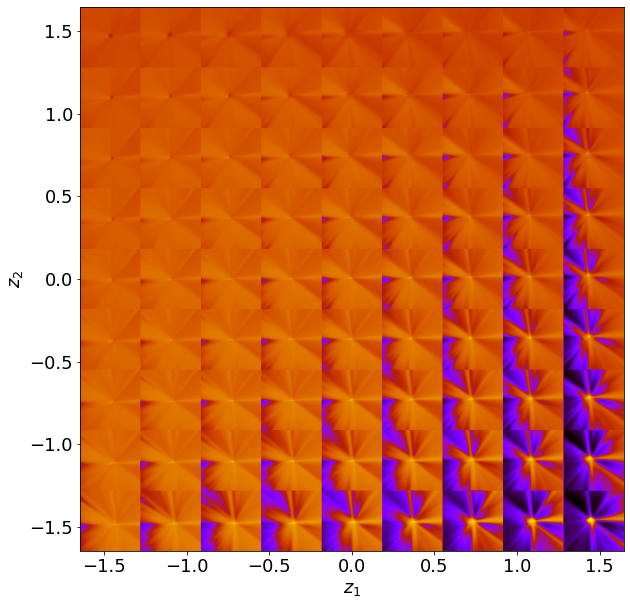

array([[0.51059581, 0.52973264, 0.54705327, ..., 0.30721425, 0.31760992,
        0.32649702],
       [0.51253611, 0.53479886, 0.55411922, ..., 0.31068435, 0.32219725,
        0.34295269],
       [0.50583154, 0.53443052, 0.55763262, ..., 0.31914857, 0.34436702,
        0.38929823],
       ...,
       [0.65528075, 0.65585611, 0.65593923, ..., 0.62837444, 0.63031964,
        0.63192326],
       [0.6548925 , 0.65491854, 0.65485371, ..., 0.62604346, 0.6283298 ,
        0.63039958],
       [0.65365598, 0.65358677, 0.6537228 , ..., 0.62415415, 0.62618257,
        0.62838102]])

In [ ]:
rvae.manifold2d()

View latent variable distributions

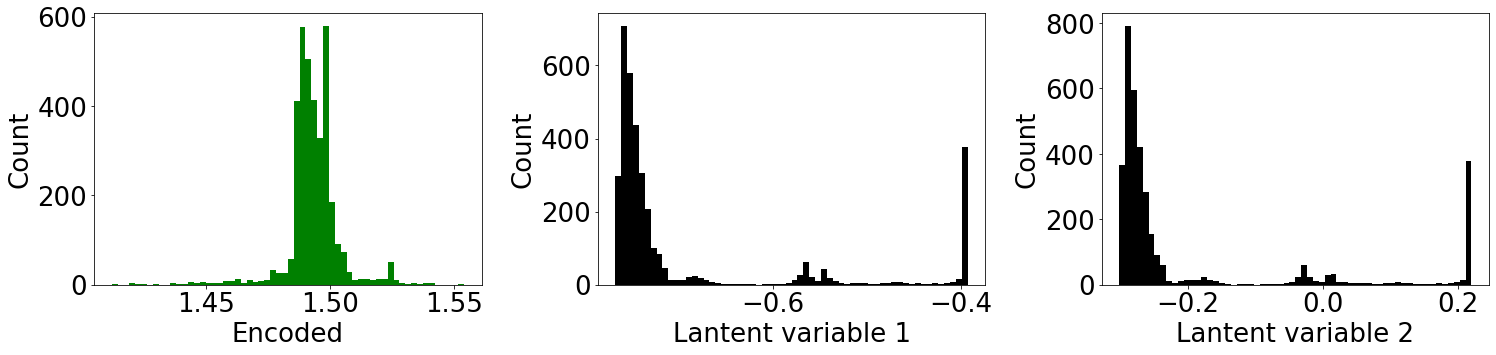

In [ ]:
z_mean, z_sd = rvae.encode(stack)
z1, z2 , z3 = z_mean[:,0], z_mean[:, 1:3], z_mean[:, 3:]

plt.rcParams.update({'font.size':26})
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
ax[0].hist(z1, bins=60, color='green')
ax[1].hist(z2[:, 0], bins=60, color='k')
ax[2].hist(z2[:, 1], bins=60, color='k')
ax[0].set_xlabel("Encoded")
ax[1].set_xlabel("Lantent variable 1") #X-offset for rVAE, L1 for rrVAE
ax[2].set_xlabel("Lantent variable 2") #Y-offset for rVAE, L2 for rrVAE
for _ax in fig.axes:
    _ax.set_ylabel("Count")
    # _ax.tick_params(labelsize=15)
plt.subplots_adjust(wspace=0.3)

View spatial location of latent variables

In [ ]:
xs = np.arange(0,int(len(stack)**0.5))
ys = np.arange(0,int(len(stack)**0.5))
xv, yv = np.meshgrid(xs, ys)

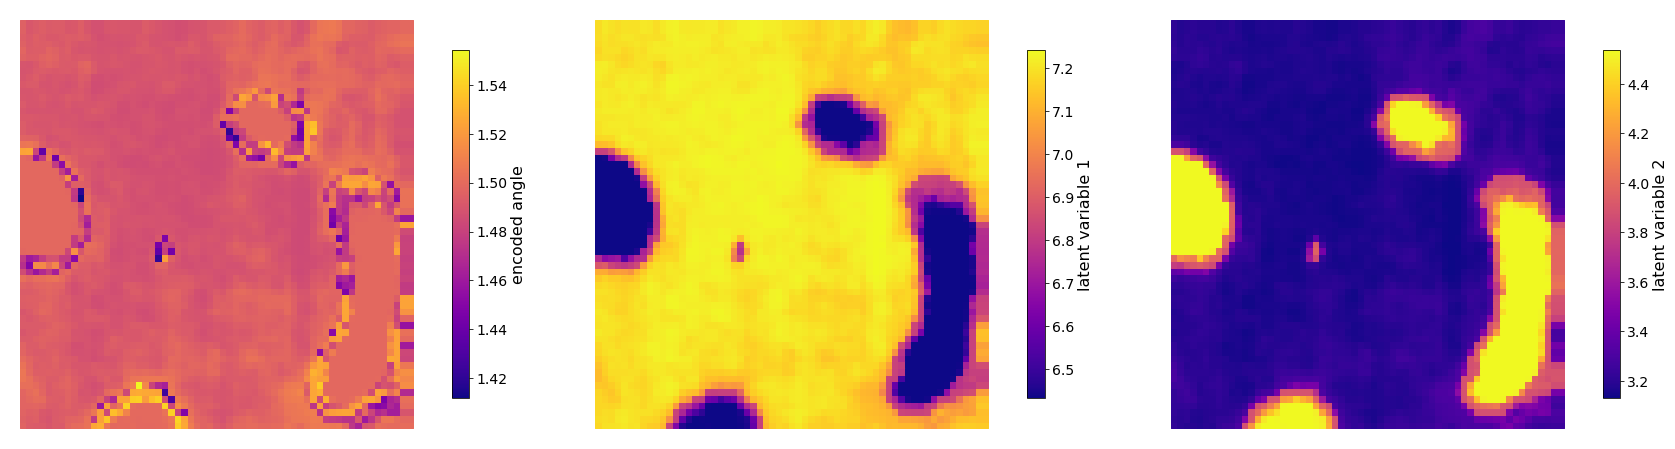

In [ ]:
work_image = imagedata
z1_i = z1 # get latent variables (image) for this frame
z3_i = z3 # get latent variables (image) for this frame
z2_i = z2

fig, axes = plt.subplots(1, 3, figsize = (30,8))
fig.subplots_adjust(wspace=0.1)

im1 = axes[0].scatter(xv.ravel(), yv.ravel(), c = z1_i,  s=160,marker='s', cmap="plasma")
cbar1 = fig.colorbar(im1, ax=axes[0], shrink=.8)
cbar1.set_label("encoded angle", fontsize=16)
cbar1.ax.tick_params(labelsize=14)
axes[0].axis('off')

im2 = axes[1].scatter(xv.ravel(), yv.ravel(), c = z3_i[:,0], s=160,marker='s', cmap="plasma")
cbar2 = fig.colorbar(im2, ax=axes[1], shrink=.8)
cbar2.set_label("latent variable 1", fontsize=16)
cbar2.ax.tick_params(labelsize=14)
axes[1].axis('off')

im3 = axes[2].scatter(xv.ravel(), yv.ravel(), c = z3_i[:,1], s=160,marker='s', cmap="plasma")
cbar3 = fig.colorbar(im3, ax=axes[2], shrink=.8)
cbar3.set_label("latent variable 2", fontsize=16)
cbar3.ax.tick_params(labelsize=14)
axes[2].axis('off')

plt.show()

Choose the component which will be the variable of interest.  

(-0.5, 59.5, 59.5, -0.5)

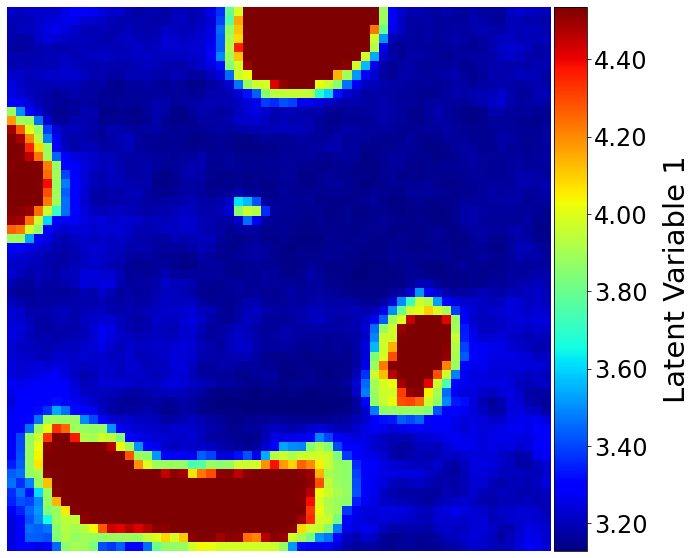

In [ ]:
index = 1 # --> can pick which latent variable
k=int(len(stack)**0.5)
aimg = z3[:,index].reshape(k,k).T 

fig,ax= plt.subplots(figsize=(12,10))
im = ax.imshow(aimg, cmap = 'jet', interpolation = 'none')
divider = make_axes_locatable(ax)
# Append axes to the right of ax3, with 10% width of ax
cax = divider.append_axes("right", size="6%", pad=0.05)

cbar=plt.colorbar(im, cax = cax, format="%.2f")
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Latent Variable 1',fontsize=29)
cbar.ax.tick_params(labelsize=24) 

ax.axis('off')

#Prepare Data for Simulated Data Collection

Here we are going to prepare a blank data set, removing all but 1 data point from our chosen abundance map.

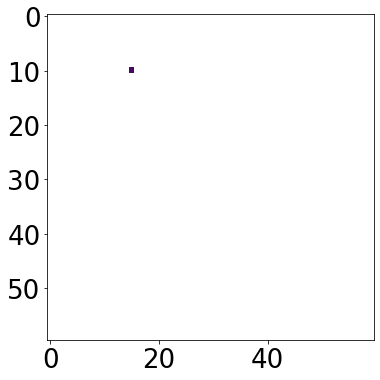

In [ ]:
blank_data = np.empty(aimg.shape)
blank_data[:] = np.nan

seed = [(10,15)] # location in pixels, feel free to change or add more
for ii in range(len(seed)):
  blank_data[seed[ii]] = aimg[seed[ii]]

plt.figure(figsize=(6,6))
plt.imshow(blank_data,vmin = np.min(aimg),vmax=np.max(aimg))

Set up Bayesian Optimization for predicting next point.

In [ ]:
Z_sparse = blank_data
X_sparse = gpim.utils.get_sparse_grid(Z_sparse)
X_full = gpim.utils.get_full_grid(Z_sparse)
idx = seed
points_measured = [xy_to_pixind(x,y, num_cols=28) for (x,y) in idx]
mask = get_mask(Z_sparse, points_measured)

# Bayesian Optimization

In [ ]:
lengthscale = [1.,20.]
batch_out_max = 10
kernel = 'RationalQuadratic' #'RBF', 'Matern52', 'RationalQuadratic'
batch_size = 500
exploration_steps = 50
gp_iterations = 300
acquisition = 'poi' # acq, 'cb', 'poi', 'ei'


boptim = gpim.boptimizer(
  X_sparse, Z_sparse, X_full,
  trial_func, acquisition_function= acquisition, batch_update = True, lengthscale = lengthscale,
  batch_out_max = batch_out_max,kernel = kernel, mask = mask,
  exploration_steps=exploration_steps,batch_size=batch_size,gp_iterations=gp_iterations,
  use_gpu=True,
  verbose=2)

Run BO

In [ ]:
boptim.run() #  Run Bayesian optimization


Exploration step 1 / 50
Model training...
iter: 0 ... loss: 7.8195 ... amp: 8.8568 ... length: 7.8797 ... noise: 1.0512707 ...
iter: 100 ... loss: 7.8194 ... amp: 8.9699 ... length: 7.8797 ... noise: 1.0723455 ...
average time per iteration: 0.0079 s
iter: 200 ... loss: 7.8194 ... amp: 8.97 ... length: 7.8797 ... noise: 1.0724202 ...
iter: 299 ... loss: 7.8194 ... amp: 8.97 ... length: 7.8797 ... noise: 1.0724175 ...
training completed in 2.12 s
Final parameter values:
 amp: 8.97, lengthscale: 7.8797, noise: 1.0724175
Computing acquisition function...
Acquisition function max value 0.49720021340207166 at [10, 15]
Model training...
iter: 0 ... loss: 24.999 ... amp: 8.9229 ... length: 8.1006 ... noise: 1.0201151 ...
iter: 100 ... loss: 13.9025 ... amp: 5.379 ... length: 17.6325 ... noise: 0.0294023 ...
average time per iteration: 0.006999999999999999 s
iter: 200 ... loss: 13.7191 ... amp: 7.9849 ... length: 17.861 ... noise: 0.0185816 ...
iter: 299 ... loss: 13.6945 ... amp: 8.6372 ... 

View Results

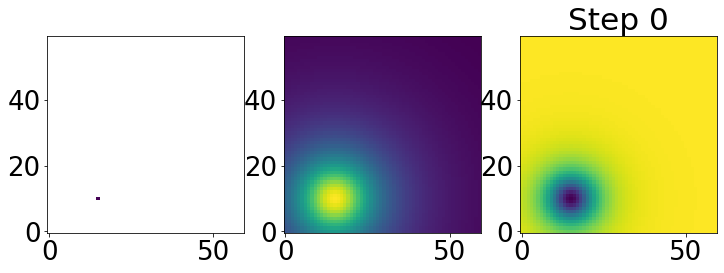

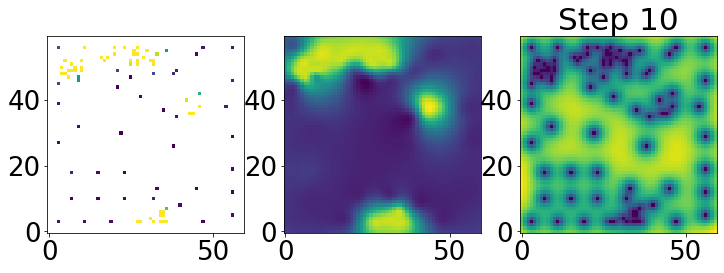

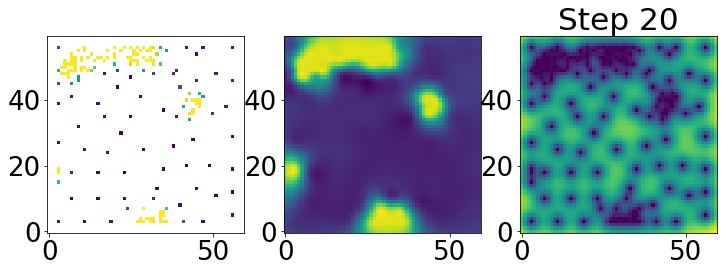

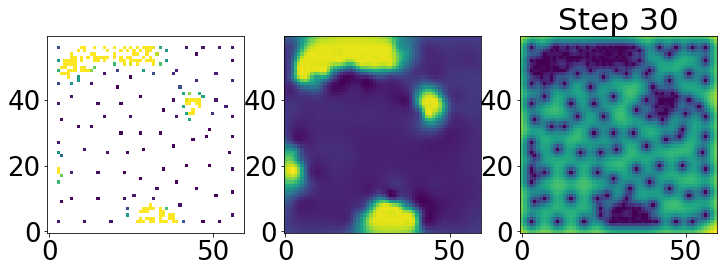

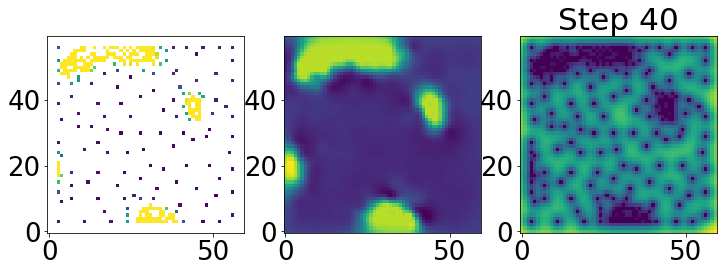

In [ ]:
func_val, gp_pred = boptim.target_func_vals, boptim.gp_predictions
for i, (func, pred) in enumerate(zip(func_val, gp_pred)):
    if i%10 == 0:
      _, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
      ax1.imshow(func, origin='bottom')
      ax2.imshow(pred[0], origin='bottom')
      ax3.imshow(pred[1], origin='bottom')
      plt.title('Step {}'.format(i))
      plt.show()
    else:
      continue

# Quantify Results

##Image Reconstruction

Calculate the accuracy of reproducing the full data given the sparse dataset using a structural similarity index measure (SSIM).

In [ ]:
from skimage.metrics import structural_similarity as ssim
comp = []
avg_unc = []
for i, (func, pred) in enumerate(zip(func_val, gp_pred)):
  comp.append(ssim(aimg,pred[0],data_range=aimg[0].max()-aimg[0].min()))

  avg_unc.append(np.mean(pred[1]))

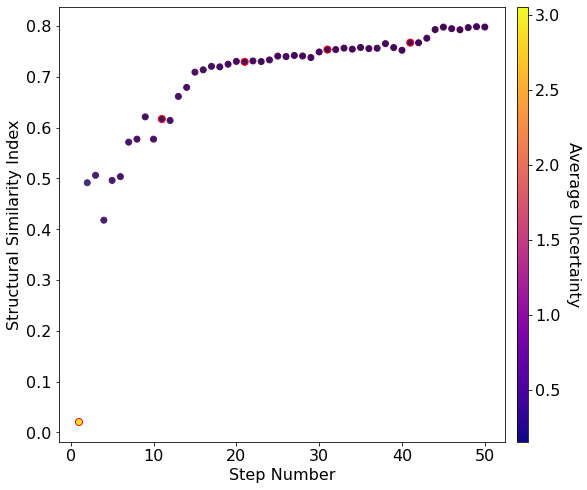

In [ ]:
plt.rcParams.update({'font.size': 16})

fig,ax = plt.subplots(figsize=(8,8))
cbaxs = fig.add_axes([0.92,0.125,0.02,0.755])

ax.scatter(np.arange(1,exploration_steps+1),comp,c=avg_unc)
ax.set_ylabel('Structural Similarity Index')
ax.set_xlabel('Step Number')

scbar = plt.cm.ScalarMappable(cmap=plt.cm.plasma,norm=plt.Normalize(vmin=np.asarray(avg_unc).min(),vmax=np.asarray(avg_unc).max()))

scbar._A=[]
cbar = plt.colorbar(scbar,cax=cbaxs)
cbar.ax.set_ylabel('Average Uncertainty',rotation=270,labelpad=20)

sub_10 = [comp[x] for x in range(len(comp)) if x%10==0]
ax.scatter(np.arange(1,exploration_steps+1,10),sub_10,s=50,facecolors='none', edgecolors='r')

##BO Efficiency

Here we will quantify the efficiency of the BO by calculating the percentage of region of interest we were able to locate. 

In [ ]:
sigma2 = np.std(np.ravel(aimg))**2
bw = np.where(aimg>sigma2,1,0)
locs0=np.argwhere(bw>0)
locs = [ list(item) for item in locs0 ]
locs = [x for x in locs if x[0]>3 and x[0]<aimg.shape[0]-3 and x[1]>3 and x[1]< aimg.shape[1]-3]
counter = []
for ii in range(len(func_val)):
  locs_bo=np.argwhere(~np.isnan(func_val[ii]))
  counter.append(np.sum([1 for x in locs_bo if list(x) in locs]))

fig,ax=plt.subplots(figsize=(6,6))
ax.plot(np.asarray(counter)/len(locs),'k',linewidth=3)
sub_10 = [counter[x]/len(locs) for x in range(exploration_steps+1) if x%10==0]
ax.scatter(np.arange(0,exploration_steps+1,10),sub_10,s=50,facecolors='None', edgecolors='r')
ax.set_xlabel('Exploration Steps')
ax.set_ylabel('Percentage of Feature of Interest Collected')